In [1]:
import torch
import torch.nn as nn
import timm
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset


from lightning.fabric import Fabric

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [2]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [3]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 1
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2
# dropout = 0.6990787087509548

k_folds = 5

In [4]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]



400
400
400
400
400


In [5]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
            
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

In [6]:
torch.cuda.empty_cache()

In [7]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 5:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 5:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1
            
    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):  
            
    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if (tp > 0 and tn > 0) else 0
    return tss
    
def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1





FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/800 [00:00<?, ?it/s]

Average Training Loss:  3.027142787736375


Validation Progress: Epoch: 1:   0%|          | 0/200 [00:00<?, ?it/s]

Average Validation Loss:  1.759830071013421


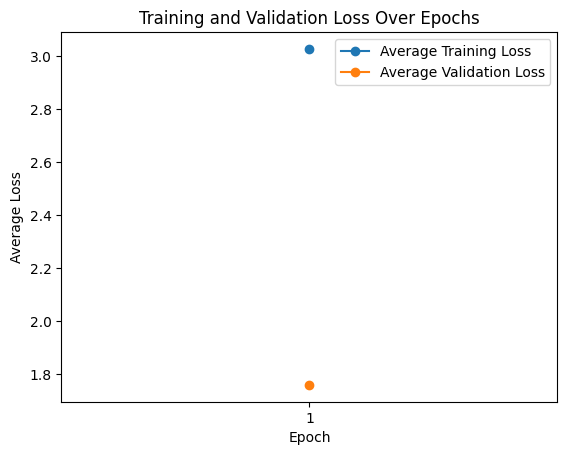

Testing Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Label:  tensor([1., 2.], device='cuda:0')
Label:  tensor([4.0000, 1.6670], device='cuda:0')
Label:  tensor([2.0000, 0.6670], device='cuda:0')
Label:  tensor([2., 4.], device='cuda:0')
Label:  tensor([2., 2.], device='cuda:0')
Label:  tensor([2.6670, 4.0000], device='cuda:0')
Label:  tensor([2., 1.], device='cuda:0')
Label:  tensor([2.0000, 3.3330], device='cuda:0')
Label:  tensor([1.6670, 2.0000], device='cuda:0')
Label:  tensor([3.3330, 2.3330], device='cuda:0')
Label:  tensor([4.6670, 1.3330], device='cuda:0')
Label:  tensor([1.6670, 3.0000], device='cuda:0')
Label:  tensor([2.0000, 1.6670], device='cuda:0')
Label:  tensor([3.3330, 3.0000], device='cuda:0')
Label:  tensor([2.6670, 2.6670], device='cuda:0')
Label:  tensor([2., 2.], device='cuda:0')
Label:  tensor([0.6670, 1.3330], device='cuda:0')
Label:  tensor([3.0000, 1.6670], device='cuda:0')
Label:  tensor([3.3330, 1.3330], device='cuda:0')
Label:  tensor([0.6670, 3.3330], device='cuda:0')
Label:  tensor([2.0000, 2.3330], device=

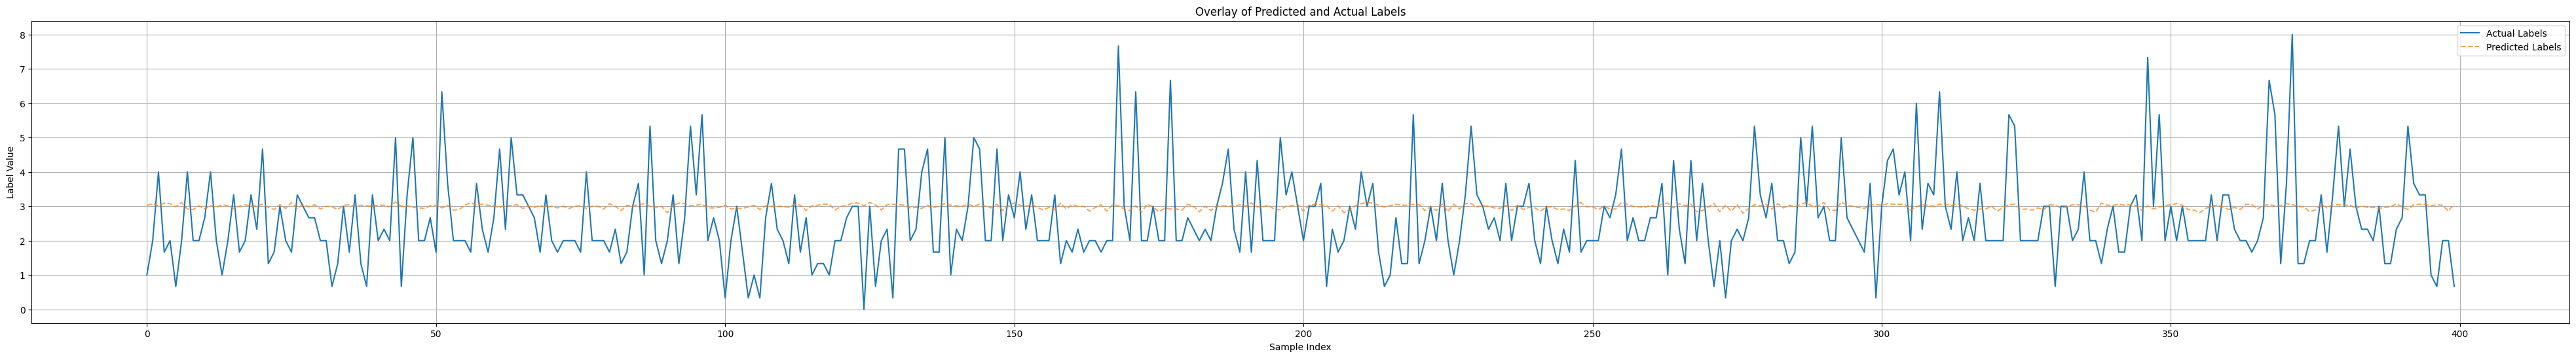

[3.03125, 3.078125, 3.015625, 3.09375, 3.078125, 2.984375, 3.109375, 2.921875, 2.90625, 3.015625, 2.921875, 3.015625, 2.96875, 3.046875, 3.015625, 2.9375, 3.0, 3.046875, 3.0, 3.015625, 3.0625, 2.96875, 2.90625, 3.046875, 2.9375, 3.109375, 2.9375, 3.046875, 2.984375, 3.046875, 2.921875, 3.0, 2.984375, 2.90625, 3.03125, 3.046875, 3.0, 3.03125, 3.015625, 3.0, 3.03125, 3.03125, 2.984375, 3.125, 3.0, 3.015625, 2.96875, 2.953125, 2.9375, 3.015625, 3.03125, 2.953125, 3.03125, 2.890625, 2.90625, 3.03125, 3.109375, 3.03125, 3.0625, 3.03125, 3.015625, 2.96875, 3.03125, 3.015625, 3.046875, 2.9375, 3.0, 2.96875, 3.03125, 2.96875, 3.0, 2.953125, 3.0, 2.9375, 3.0, 3.015625, 2.9375, 3.0, 3.0, 2.921875, 3.078125, 3.0, 2.875, 3.03125, 3.0, 3.046875, 3.078125, 3.0, 2.96875, 3.0, 2.8125, 3.03125, 3.09375, 3.078125, 3.015625, 3.03125, 3.0625, 2.953125, 2.953125, 2.96875, 3.03125, 2.921875, 2.9375, 2.9375, 2.984375, 3.03125, 2.90625, 3.015625, 3.0, 3.0, 3.0, 2.96875, 3.0625, 3.03125, 2.875, 3.015625, 3.031

Training Progress: Epoch: 1:   0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:

total_avg_test_loss = 0
total_rmse = 0
total_mse = 0
total_mae = 0
total_r2 = 0
total_tts = 0
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0

for i in range(k_folds):
    print(f'FOLD {i + 1}')
    print('--------------------------------')
    test_indices = dataloaders[i]
    train_indices = []
    for j in range(k_folds):
        if j != i:
            train_indices += dataloaders[j]
    
    trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=10)
    testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=True, num_workers=10)
    
    trainloader = fabric.setup_dataloaders(trainloader)
    testloader = fabric.setup_dataloaders(testloader)
    
    # Reinitialize model
    
    model = GmiSwinTransformer(hidden_size=hidden_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model, optimizer = fabric.setup(model, optimizer)
    model.train()
    
    # Training the model
    n_total_steps = len(trainloader)
    avg_train_loss_over_epochs = []
    avg_val_loss_over_epochs = []

    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []
        
        # Training loop
        model.train()
        for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
            # Move images and labels to device
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)  # Change shape to [5, 10, 1, 224, 224]
            labels = labels.float()

            # Forward pass with autograd
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            fabric.backward(loss)
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())
        
        # Store the average training loss for this epoch
        avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
        print("Average Training Loss: ", sum(train_losses) / len(train_losses))
        
        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                images = images.float()
                # images = images.permute(1, 0, 2, 3, 4)
                labels = labels.float()
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                # print("Validation Loss: ", loss.item())
                val_losses.append(loss.item())
        
        # Store the average validation loss for this epoch
        avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
        print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

    # Plot loss over epochs
    plt.figure()
    plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()
    
    test_losses = []
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Testing Progress"):
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)
            labels = labels.float()
            # print("Label: ", labels)
            outputs = model(images).squeeze(1)
            # print("Output: ", outputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses)
    rmse = math.sqrt(avg_test_loss)
    mse = mean_squared_error(all_labels, all_outputs)
    mae = mean_absolute_error(all_labels, all_outputs)
    r2 = r2_score(all_labels, all_outputs)
    tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
    accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
    tts = true_skill_score(tp, tn, fp, fn)
    
    
    
    # Accumulate metrics for averaging across folds
    total_avg_test_loss += avg_test_loss
    total_rmse += rmse
    total_mse += mse
    total_mae += mae
    total_r2 += r2
    total_tts += tts
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    
    

    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'True Skill Score: {tts:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    
    plt.figure(figsize=(50, 6))

    plt.plot(all_labels, '-', label='Actual Labels')
    plt.plot(all_outputs, '--', label='Predicted Labels', alpha=0.7)

    plt.xlabel('Sample Index')
    plt.ylabel('Label Value')
    plt.title('Overlay of Predicted and Actual Labels')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(all_outputs)
    
# Average metrics across all folds
total_avg_test_loss /= k_folds
total_rmse /= k_folds
total_mse /= k_folds
total_mae /= k_folds
total_r2 /= k_folds
total_tts /= k_folds
total_accuracy /= k_folds
total_precision /= k_folds
total_recall /= k_folds
total_f1 /= k_folds

print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
print(f'Average RMSE across all folds: {total_rmse:.4f}')
print(f'Average MSE across all folds: {total_mse:.4f}')
print(f'Average MAE across all folds: {total_mae:.4f}')
print(f'Average R² across all folds: {total_r2:.4f}')
print(f'Average True Skill Score across all folds: {total_tts:.4f}')
print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
print(f'Average Precision across all folds: {total_precision:.4f}')
print(f'Average Recall across all folds: {total_recall:.4f}')
print(f'Average F1 Score across all folds: {total_f1:.4f}')


    